# EOF of 
- [ ] SST
- [ ] LCC
- [ ] TCC
- [ ] SSH
- [ ] EKE
- [ ] Winds
- [ ] SW/LW/SH/LH

## Load in data and resample ERA5 vars to daily, and ERA5 heat fluxes to W/m$^2$

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from eofs.xarray import Eof as eof

Matplotlib is building the font cache; this may take a moment.


In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc', chunks={})
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc', chunks={})
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc', chunks={})
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc', chunks={})

heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})

glorys = xr.open_dataset('glorys_vars.nc', chunks={})

In [3]:
heat_fluxes

<xarray.Dataset> Size: 1GB
Dimensions:    (longitude: 69, latitude: 55, time: 10408)
Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [4]:
#Resample vars from hourly to daily
sst = sst_ds.sea_surface_temperature.resample(time='1D').mean()#.sel(**time_slice)
tcc = tcc_ds.total_cloud_cover.resample(time='1D').mean()#.sel(**time_slice)
mslp = mslp_ds.mean_sea_level_pressure.resample(time='1D').mean()#.sel(**time_slice)
u10 = u10_ds['10m_u_component_of_wind'].resample(time='1D').mean()#.sel(**time_slice)
v10 = v10_ds['10m_v_component_of_wind'].resample(time='1D').mean()#.sel(**time_slice)
mask = mask_ds.land_sea_mask
lcc = lcc_ds.lcc.resample(time='1D').mean()#.sel(**time_slice)

sw = (heat_fluxes.ssr / (60*60)).resample(time='1D').mean() #W/m2
lw = (heat_fluxes.str / (60*60)).resample(time='1D').mean() #W/m2
sh = (heat_fluxes.sshf / (60*60)).resample(time='1D').mean() #W/m2
lh = (heat_fluxes.slhf / (60*60)).resample(time='1D').mean() #W/m2

sst_g = glorys.thetao.chunk({'time':1301})
ssh = glorys.zos.chunk({'time':1301})
u = glorys.uo.chunk({'time':1301})
v = glorys.vo.chunk({'time':1301})
eke = (0.5 * (u**2 + v**2)).chunk({'time':1301})

In [5]:
sst.time

<xarray.DataArray 'time' (time: 23011)> Size: 184kB
array(['1959-01-01T00:00:00.000000000', '1959-01-02T00:00:00.000000000',
       '1959-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31

In [6]:
sst_g.time

<xarray.DataArray 'time' (time: 10408)> Size: 83kB
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2021-06-28T00:00:00.000000000',
       '2021-06-29T00:00:00.000000000', '2021-06-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

## Calculate EOFs
(and save them to netcdf)

In [7]:
def eof_func(data):
    # this sets it up
    solver = eof(data) # data with a time vector
    # compute the EOF
    eofs = solver.eofs(neofs=3)
    # variance explained
    variance_fractions = solver.varianceFraction(neigs=3) # number eigenvalues
    # principal component
    pc = solver.pcs(npcs=3)

    return eofs, variance_fractions, pc

In [ ]:
sst_eof = eof_func(sst)
tcc_eof = eof_func(tcc)
mslp_eof = eof_func(mslp)
u10_eof = eof_func(u10)
v10_eof = eof_func(v10)
lcc_eof = eof_func(lcc)

sw_eof = eof_func(sw)
lw_eof = eof_func(lw)
sh_eof = eof_func(sh)
lh_eof = eof_func(lh)

In [ ]:
sst_g_eof = eof_func(sst_g)

In [ ]:
ssh_eof = eof_func(ssh)
u_eof = eof_func(u)
v_eof = eof_func(v)
eke_eof = eof_func(eke)

In [30]:
sst_g_eof[0].to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_eofs.nc')
sst_g_eof[1].to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_var_frac.nc')
sst_g_eof[2].to_netcdf('/work5/stb/MHW-gfdl/eofs/sst_g_pcs.nc')

In [30]:
ssh_eof[0].to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_eofs.nc')
ssh_eof[1].to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_var_frac.nc')
ssh_eof[2].to_netcdf('/work5/stb/MHW-gfdl/eofs/ssh_pcs.nc')

In [30]:
u_eof[0].to_netcdf('/work5/stb/MHW-gfdl/eofs/u_eofs.nc')
u_eof[1].to_netcdf('/work5/stb/MHW-gfdl/eofs/u_var_frac.nc')
u_eof[2].to_netcdf('/work5/stb/MHW-gfdl/eofs/u_pcs.nc')

In [30]:
v_eof[0].to_netcdf('/work5/stb/MHW-gfdl/eofs/v_eofs.nc')
v_eof[1].to_netcdf('/work5/stb/MHW-gfdl/eofs/v_var_frac.nc')
v_eof[2].to_netcdf('/work5/stb/MHW-gfdl/eofs/v_pcs.nc')

In [30]:
eke_eof[0].to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_eofs.nc')
eke_eof[1].to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_var_frac.nc')
eke_eof[2].to_netcdf('/work5/stb/MHW-gfdl/eofs/eke_pcs.nc')

## Plot EOFs

In [33]:
def open_ds(filename):
    ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/{filename}*.nc', chunks={})
    return ds

In [34]:
sst_eof = open_ds('sst')
tcc_eof = open_ds('tcc')
mslp_eof = open_ds('mslp')
u10_eof = open_ds('u10')
v10_eof = open_ds('v10')
lcc_eof = open_ds('lcc')

sw_eof = open_ds('sw')
lw_eof = open_ds('lw')
sh_eof = open_ds('sh')
lh_eof = open_ds('lh')

In [ ]:
sst_g_eof = open_ds('sst_g')
ssh_eof = open_ds('ssh')
u_eof = open_ds('u')
v_eof = open_ds('v')
eke_eof = open_ds('eke')

In [15]:
sst_eof

<xarray.Dataset> Size: 506kB
Dimensions:             (mode: 3, latitude: 55, longitude: 69, time: 23011)
Coordinates:
  * mode                (mode) int64 24B 0 1 2
  * latitude            (latitude) float32 220B 31.0 30.75 30.5 ... 17.75 17.5
  * longitude           (longitude) float32 276B 262.0 262.2 ... 278.8 279.0
  * time                (time) datetime64[ns] 184kB 1959-01-01 ... 2021-12-31
Data variables:
    eofs                (mode, latitude, longitude) float32 46kB dask.array<chunksize=(3, 55, 69), meta=np.ndarray>
    pcs                 (time, mode) float32 276kB dask.array<chunksize=(23011, 3), meta=np.ndarray>
    variance_fractions  (mode) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>

In [41]:
sst_eof.pcs.isel(mode=0)

<xarray.DataArray 'pcs' (time: 23011)> Size: 92kB
dask.array<getitem, shape=(23011,), dtype=float32, chunksize=(23011,), chunktype=numpy.ndarray>
Coordinates:
    mode     int64 8B 0
  * time     (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31

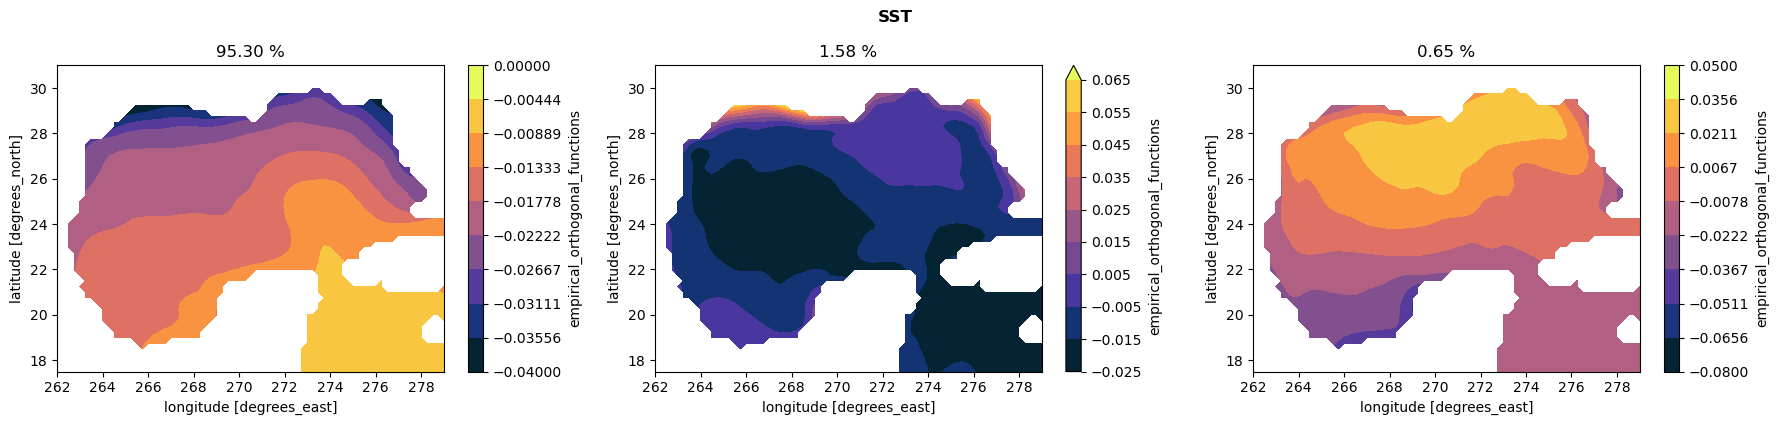

In [58]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.04, 0, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_eof.variance_fractions[0].values*100:.2f} %')

sst_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .065, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_eof.variance_fractions[1].values*100:.2f} %')

sst_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.08, .05, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_eof.variance_fractions[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('SST', fontweight='bold', y=1.05);

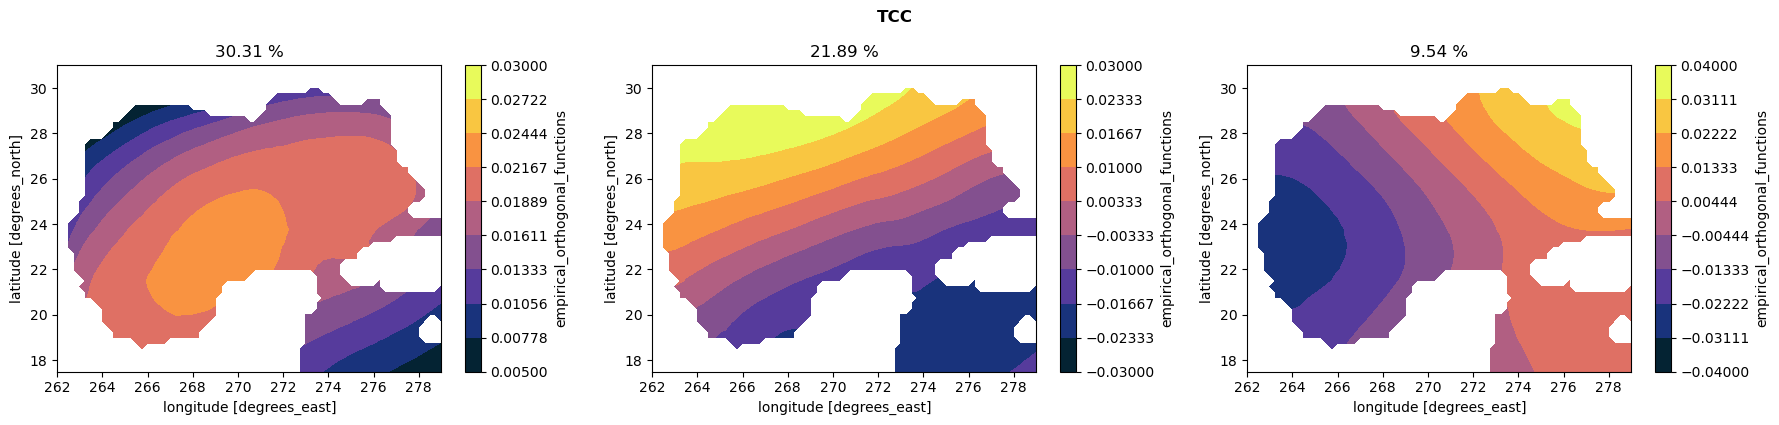

In [71]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

tcc_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.005, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{tcc_eof.variance_fractions[0].values*100:.2f} %')

tcc_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{tcc_eof.variance_fractions[1].values*100:.2f} %')

tcc_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{tcc_eof.variance_fractions[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('TCC', fontweight='bold', y=1.05);

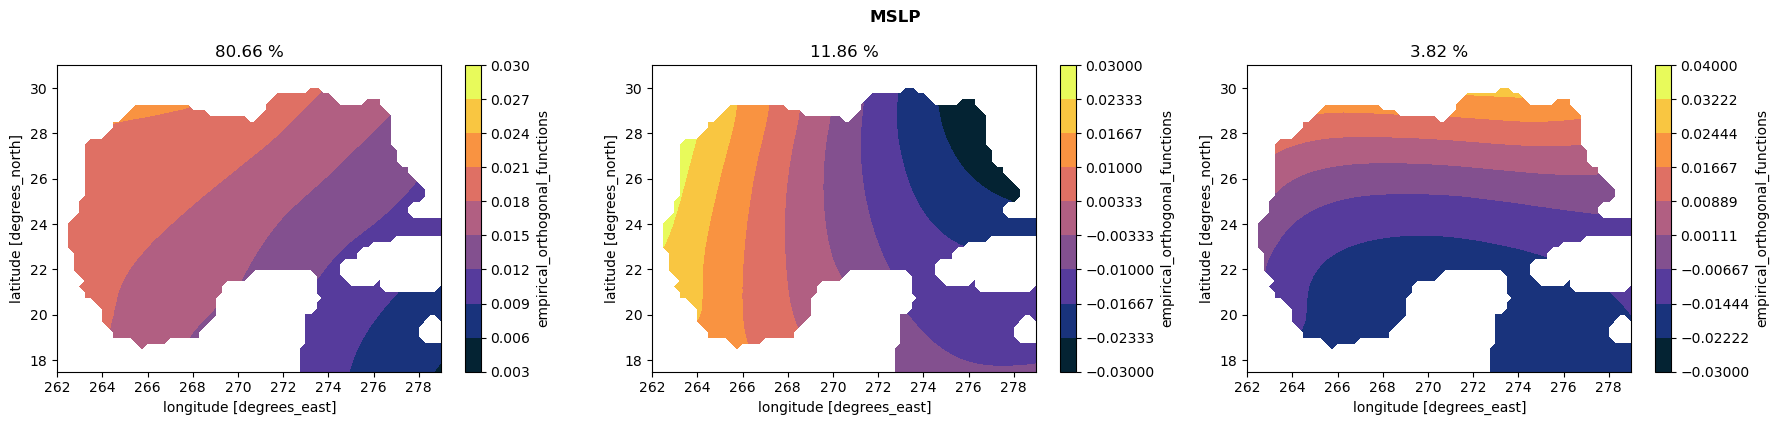

In [76]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
mslp_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.003, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{mslp_eof.variance_fractions[0].values*100:.2f} %')
mslp_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{mslp_eof.variance_fractions[1].values*100:.2f} %')
mslp_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{mslp_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('MSLP', fontweight='bold', y=1.05);

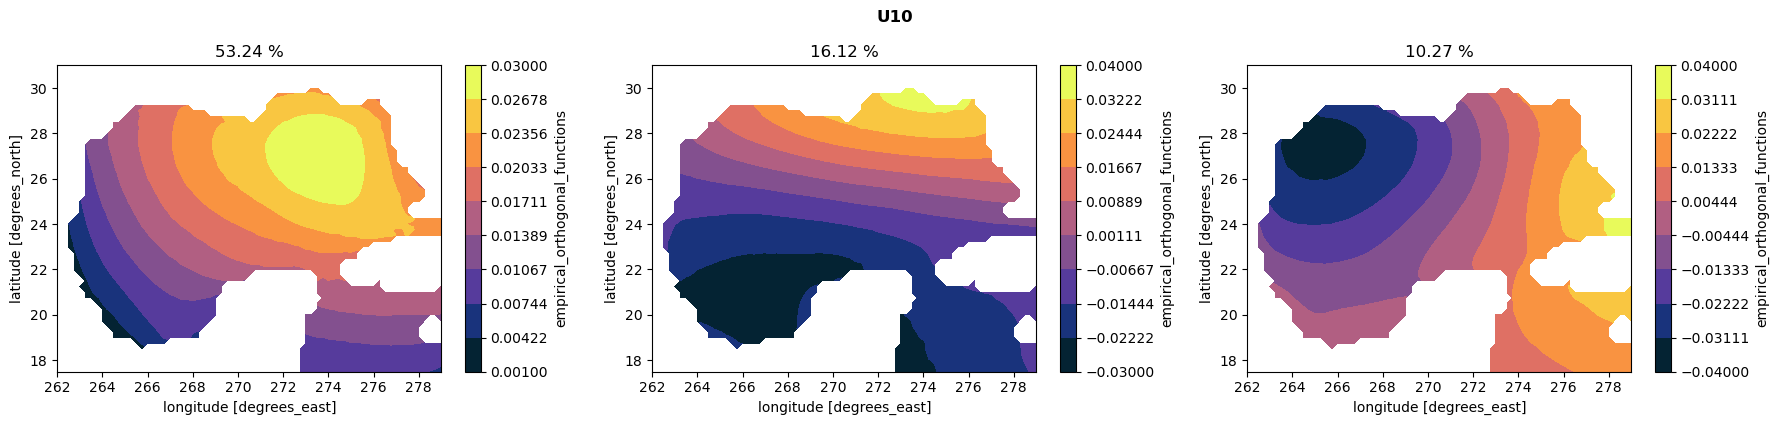

In [81]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0.001, .03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{u10_eof.variance_fractions[0].values*100:.2f} %')
u10_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, .04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{u10_eof.variance_fractions[1].values*100:.2f} %')
u10_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, .04, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{u10_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('U10', fontweight='bold', y=1.05);

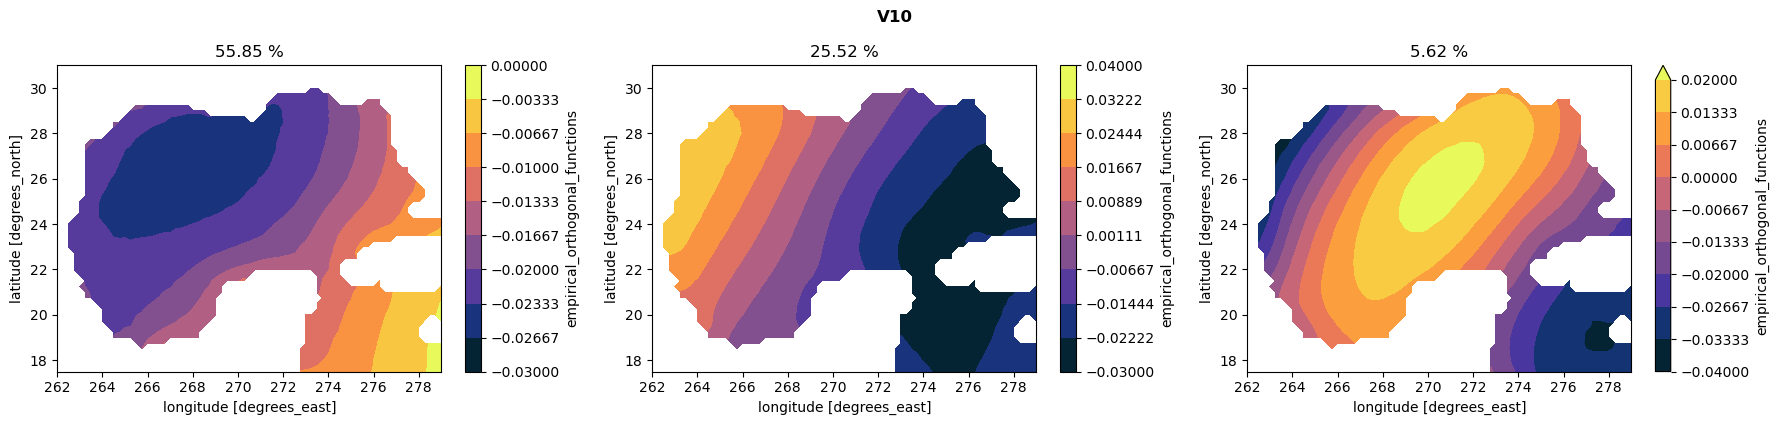

In [91]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.03, 0, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_eof.variance_fractions[0].values*100:.2f} %')
v10_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.03, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_eof.variance_fractions[1].values*100:.2f} %')
v10_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.02, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('V10', fontweight='bold', y=1.05);

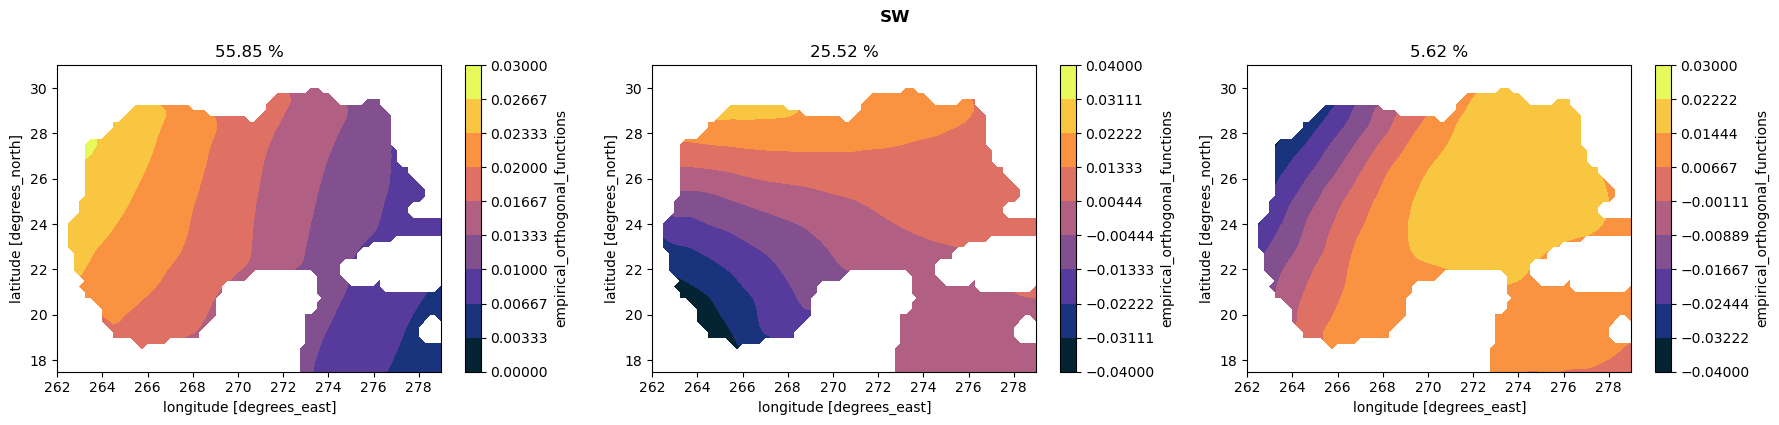

In [70]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sw_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_eof.variance_fractions[0].values*100:.2f} %')
sw_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_eof.variance_fractions[1].values*100:.2f} %')
sw_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('SW', fontweight='bold', y=1.05);

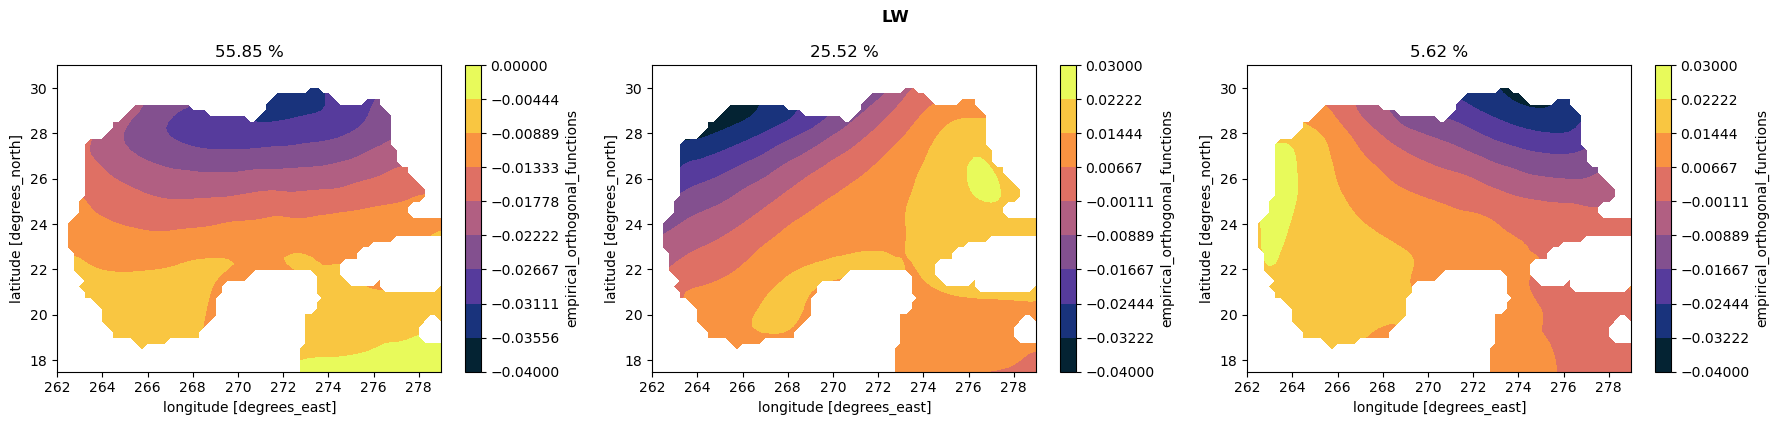

In [75]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
lw_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.04, 0, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_eof.variance_fractions[0].values*100:.2f} %')
lw_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_eof.variance_fractions[1].values*100:.2f} %')
lw_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('LW', fontweight='bold', y=1.05);

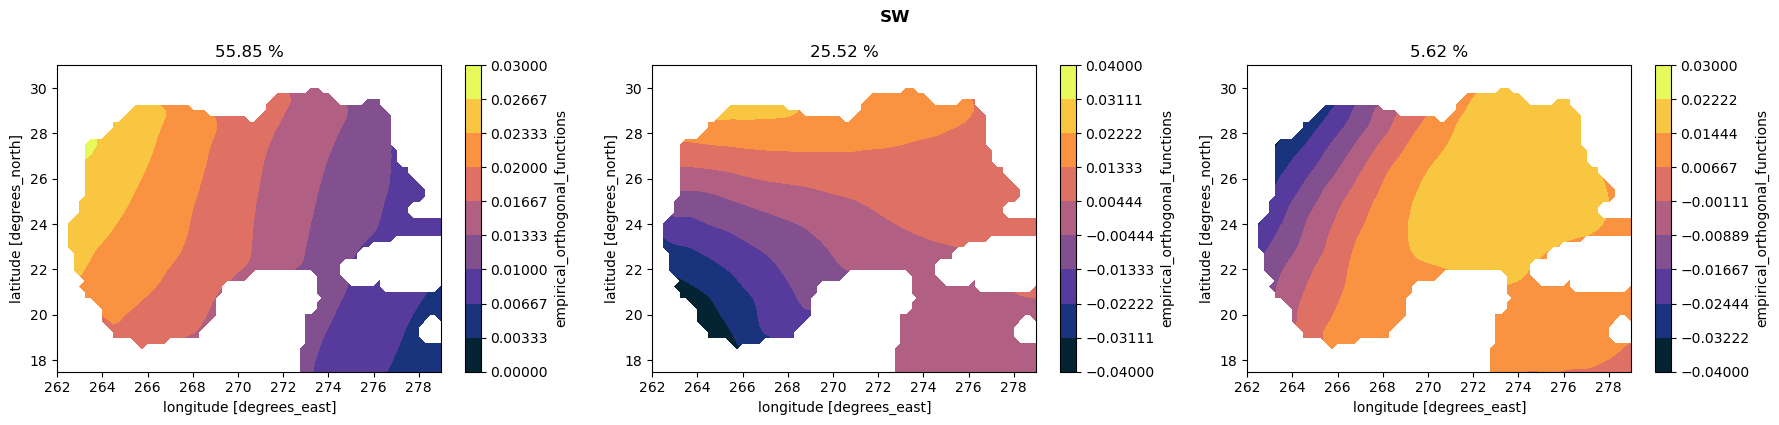

In [70]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sh_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(0, 0.03, 10),cmap=cmocean.cm.thermal)
ax[0].set_title(f'{v10_eof.variance_fractions[0].values*100:.2f} %')
sh_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.04, 0.04, 10),cmap=cmocean.cm.thermal)
ax[1].set_title(f'{v10_eof.variance_fractions[1].values*100:.2f} %')
sh_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.04, 0.03, 10),cmap=cmocean.cm.thermal)
ax[2].set_title(f'{v10_eof.variance_fractions[2].values*100:.2f} %')
plt.tight_layout()
plt.suptitle('SW', fontweight='bold', y=1.05);

## Plot PCs

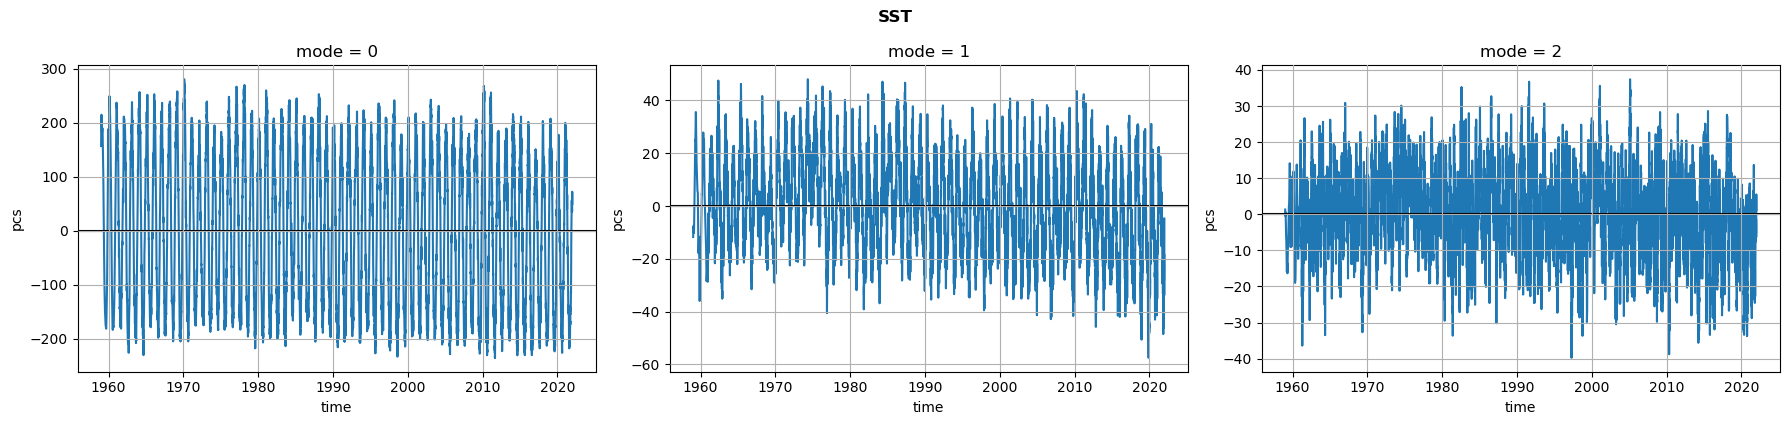

In [54]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.pcs.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

sst_eof.pcs.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

sst_eof.pcs.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('SST', fontweight='bold', y=1.05);

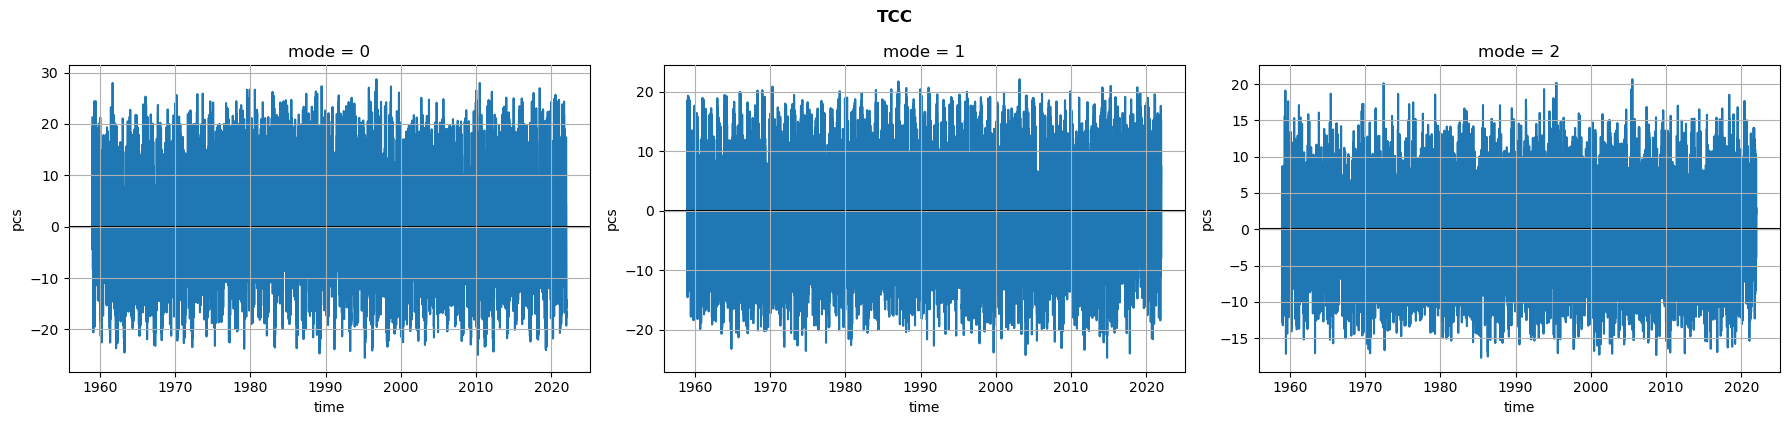

In [55]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
tcc_eof.pcs.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

tcc_eof.pcs.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

tcc_eof.pcs.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('TCC', fontweight='bold', y=1.05);

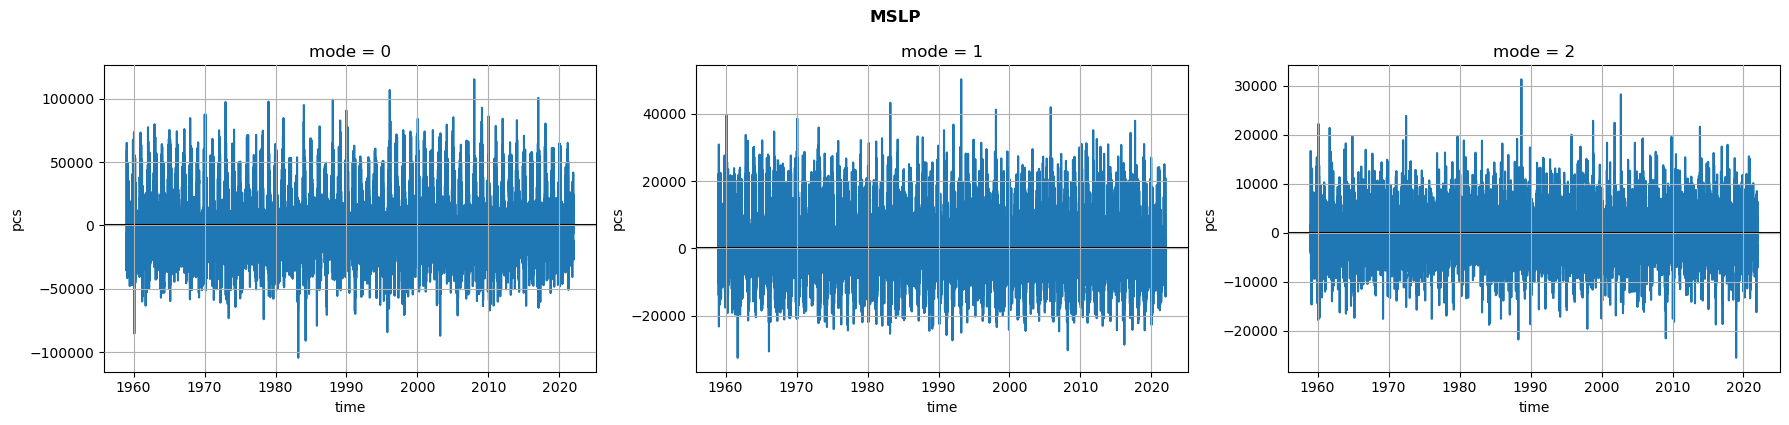

In [56]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
mslp_eof.pcs.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

mslp_eof.pcs.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

mslp_eof.pcs.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('MSLP', fontweight='bold', y=1.05);

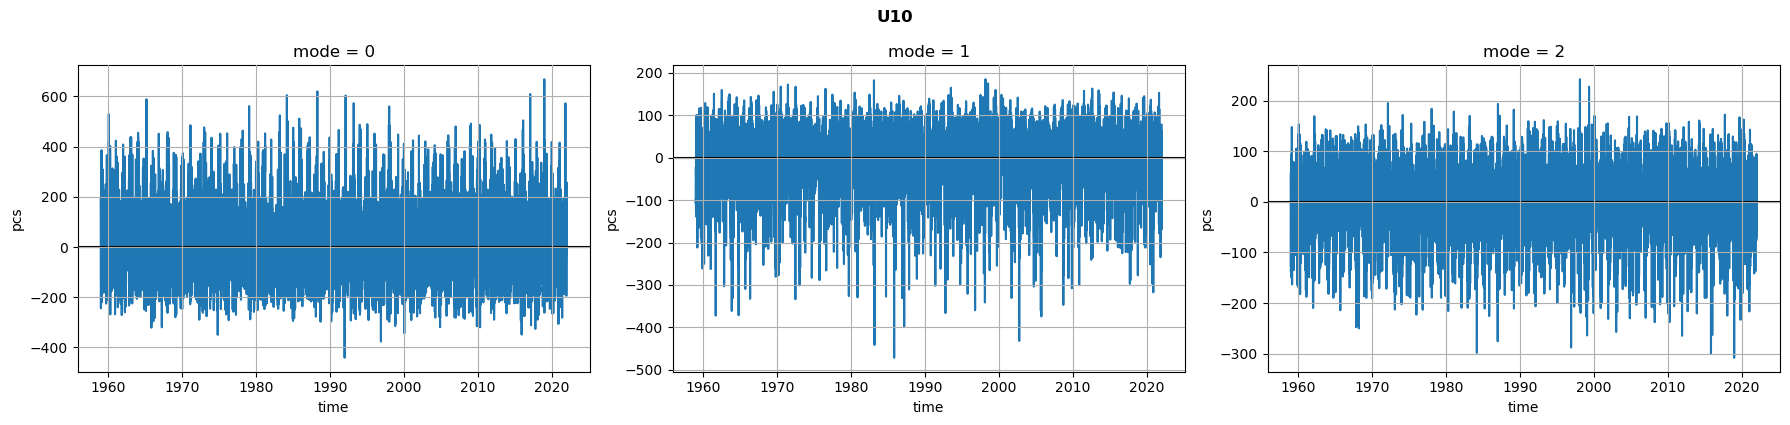

In [57]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
u10_eof.pcs.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

u10_eof.pcs.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

u10_eof.pcs.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('U10', fontweight='bold', y=1.05);

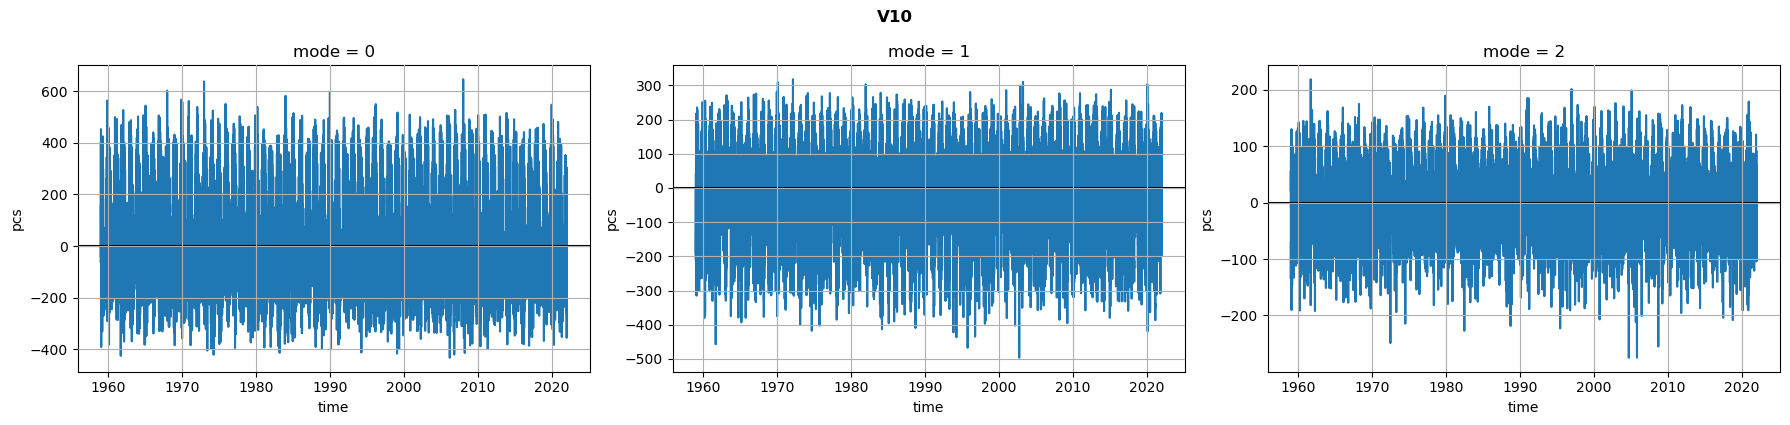

In [58]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
v10_eof.pcs.isel(mode=0).plot(ax=ax[0])
ax[0].grid('k')
ax[0].set_axisbelow(False)
ax[0].axhline(y=0, color='k')

v10_eof.pcs.isel(mode=1).plot(ax=ax[1])
ax[1].grid()
ax[1].set_axisbelow(False)
ax[1].axhline(y=0, color='k')

v10_eof.pcs.isel(mode=2).plot(ax=ax[2])
ax[2].grid()
ax[2].set_axisbelow(False)
ax[2].axhline(y=0, color='k')

plt.tight_layout()
plt.suptitle('V10', fontweight='bold', y=1.05);

## Calculate EOFs for anomalous vars
(and save them to netcdf)

In [7]:
def anom(da):
    anom = da.groupby('time.dayofyear') - da.groupby('time.dayofyear').mean('time')

    return anom

In [8]:
sst_anom = anom(sst)
tcc_anom = anom(tcc)
mslp_anom = anom(mslp)
u10_anom = anom(u10)
v10_anom = anom(v10)
lcc_anom = anom(lcc)

sw_anom = anom(sw)
lw_anom = anom(lw)
sh_anom = anom(sh)
lh_anom = anom(lh)

sst_g_anom = anom(sst_g)
ssh_anom = anom(ssh)
u_anom = anom(u)
v_anom = anom(v)
eke_anom = anom(eke)

In [38]:
eke_anom.to_netcdf('eke_anom.nc')

In [100]:
sst_eof = eof_func(sst_anom)
tcc_eof = eof_func(tcc_anom)
mslp_eof = eof_func(mslp_anom)
u10_eof = eof_func(u10_anom)
v10_eof = eof_func(v10_anom)
lcc_eof = eof_func(lcc_anom)

KilledWorker: Attempted to run task ('transpose-b7c7a37f08c35f9a77120dad4a5a0efc', 0, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://140.208.147.21:33353. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

## Plot EOFs of anomalies

In [10]:
def open_ds(filename):
    ds = xr.open_mfdataset(f'/work5/stb/MHW-gfdl/eofs/{filename}*.nc', chunks={})
    return ds

In [13]:
sst_eof = open_ds('sst')
tcc_eof = open_ds('tcc')
mslp_eof = open_ds('mslp')
u10_eof = open_ds('u10')
v10_eof = open_ds('v10')
lcc_eof = open_ds('lcc')

In [15]:
sst_eof

<xarray.Dataset> Size: 506kB
Dimensions:             (mode: 3, latitude: 55, longitude: 69, time: 23011)
Coordinates:
  * mode                (mode) int64 24B 0 1 2
  * latitude            (latitude) float32 220B 31.0 30.75 30.5 ... 17.75 17.5
  * longitude           (longitude) float32 276B 262.0 262.2 ... 278.8 279.0
  * time                (time) datetime64[ns] 184kB 1959-01-01 ... 2021-12-31
Data variables:
    eofs                (mode, latitude, longitude) float32 46kB dask.array<chunksize=(3, 55, 69), meta=np.ndarray>
    pcs                 (time, mode) float32 276kB dask.array<chunksize=(23011, 3), meta=np.ndarray>
    variance_fractions  (mode) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>

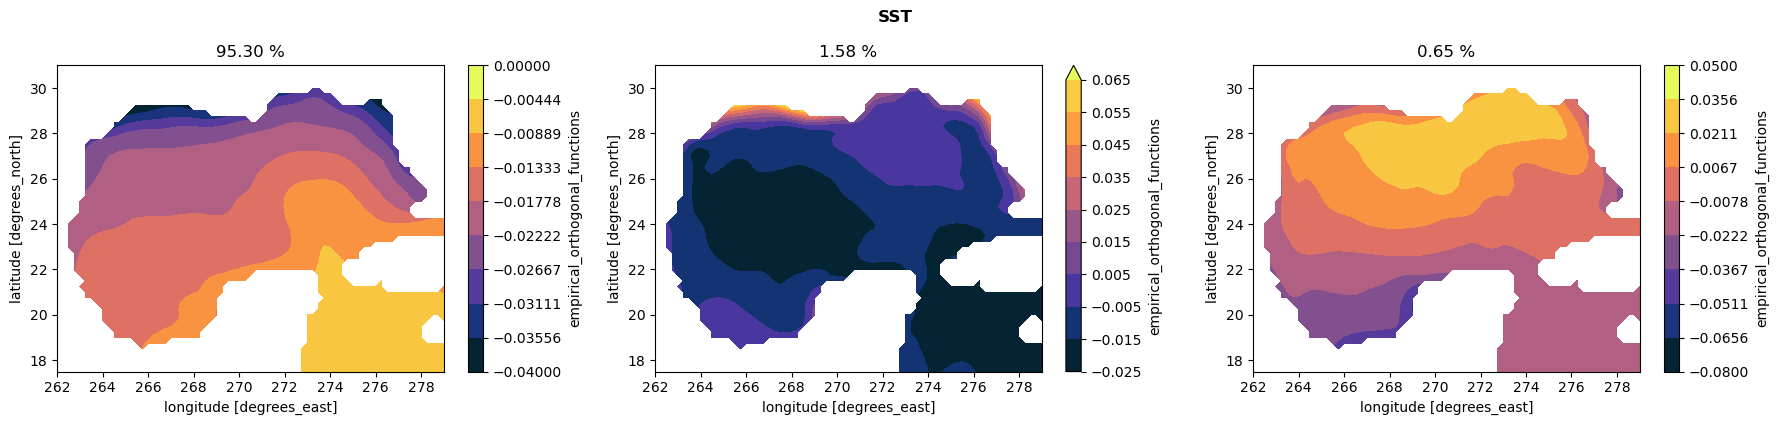

In [58]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
sst_eof.eofs[0].where(mask==0).plot.contourf(ax=ax[0], levels=np.linspace(-0.04, 0, 10), cmap=cmocean.cm.thermal)
ax[0].set_title(f'{sst_eof.variance_fractions[0].values*100:.2f} %')

sst_eof.eofs[1].where(mask==0).plot.contourf(ax=ax[1], levels=np.linspace(-0.025, .065, 10), cmap=cmocean.cm.thermal)
ax[1].set_title(f'{sst_eof.variance_fractions[1].values*100:.2f} %')

sst_eof.eofs[2].where(mask==0).plot.contourf(ax=ax[2], levels=np.linspace(-0.08, .05, 10), cmap=cmocean.cm.thermal)
ax[2].set_title(f'{sst_eof.variance_fractions[2].values*100:.2f} %')

plt.tight_layout()
plt.suptitle('SST', fontweight='bold', y=1.05);

## Plot PCs of anomalies